# Example: Orbit Integration with the Velocity Verlet Method

This notebook demonstrates how to integrate orbits numerically using the **Velocity Verlet** algorithm. We will:

1. Explain the Velocity Verlet integrator and why it's preferred for orbital dynamics
2. Implement the integrator in Python
3. Test it on a circular orbit in a Keplerian potential (where we know the exact solution)
4. Verify energy conservation

**This notebook is preparation for Problem 3.** Make sure you understand the algorithm before proceeding.

---
## 1. Why Velocity Verlet?

When integrating orbits, we need to solve Newton's equations:
$$\frac{d\mathbf{x}}{dt} = \mathbf{v}, \quad \frac{d\mathbf{v}}{dt} = \mathbf{a}(\mathbf{x})$$

The simplest approach is the **Euler method**:
$$\mathbf{x}_{n+1} = \mathbf{x}_n + \mathbf{v}_n \Delta t$$
$$\mathbf{v}_{n+1} = \mathbf{v}_n + \mathbf{a}_n \Delta t$$

However, Euler has two major problems:
- **Low accuracy**: Errors accumulate as $\mathcal{O}(\Delta t)$ (first-order)
- **Energy drift**: Total energy systematically increases over time

The **Velocity Verlet** method solves both problems:
- **Higher accuracy**: Errors scale as $\mathcal{O}(\Delta t^2)$ (second-order)
- **Symplectic**: Preserves phase-space structure, so energy oscillates but doesn't drift

### The Velocity Verlet Algorithm

Given position $\mathbf{x}_n$, velocity $\mathbf{v}_n$, and acceleration $\mathbf{a}_n = \mathbf{a}(\mathbf{x}_n)$:

**Step 1: Update position**
$$\mathbf{x}_{n+1} = \mathbf{x}_n + \mathbf{v}_n \Delta t + \frac{1}{2}\mathbf{a}_n \Delta t^2$$

**Step 2: Compute new acceleration** (at the new position)
$$\mathbf{a}_{n+1} = \mathbf{a}(\mathbf{x}_{n+1})$$

**Step 3: Update velocity** (using the AVERAGE of old and new accelerations)
$$\mathbf{v}_{n+1} = \mathbf{v}_n + \frac{1}{2}(\mathbf{a}_n + \mathbf{a}_{n+1}) \Delta t$$

The key insight is Step 3: we use the **average** acceleration, not just the old one. This is what makes the method second-order accurate and symplectic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
## 2. Test Problem: Circular Orbit in Keplerian Potential

We'll test our integrator on a problem where we know the exact answer: a circular orbit around a point mass.

### The Keplerian Potential

$$\Phi(r) = -\frac{GM}{r}$$

The acceleration (force per unit mass) is:
$$\mathbf{a} = -\nabla\Phi = -\frac{GM}{r^2}\hat{r} = -\frac{GM}{r^3}\mathbf{r}$$

In Cartesian coordinates:
$$a_x = -\frac{GM \cdot x}{r^3}, \quad a_y = -\frac{GM \cdot y}{r^3}$$

### Circular Orbit

For a circular orbit at radius $r_0$, the circular velocity is:
$$v_c = \sqrt{\frac{GM}{r_0}}$$

and the orbital period is:
$$T = \frac{2\pi r_0}{v_c} = 2\pi\sqrt{\frac{r_0^3}{GM}}$$

We'll use units where $GM = 1$ for simplicity.

In [ ]:
# Physical setup (units where GM = 1)
GM = 1.0

def acceleration_kepler(pos, GM=1.0):
    """
    Compute gravitational acceleration in Keplerian potential.
    
    Parameters:
    -----------
    pos : array of shape (2,)
        Position [x, y]
    GM : float
        Gravitational parameter (G * M)
    
    Returns:
    --------
    acc : array of shape (2,)
        Acceleration [ax, ay]
    """
    r = np.sqrt(pos[0]**2 + pos[1]**2)  # Distance from origin
    acc = -GM / r**3 * pos              # a = -GM/r^3 * r_vec
    return acc


def potential_kepler(pos, GM=1.0):
    """Keplerian potential: Phi = -GM/r"""
    r = np.sqrt(pos[0]**2 + pos[1]**2)
    return -GM / r


def total_energy(pos, vel, GM=1.0):
    """Total energy: E = (1/2)v^2 + Phi"""
    KE = 0.5 * (vel[0]**2 + vel[1]**2)
    PE = potential_kepler(pos, GM)
    return KE + PE

---
## 3. Implement the Velocity Verlet Integrator

In [3]:
def integrate_velocity_verlet(pos_init, vel_init, acc_func, dt, n_steps, **kwargs):
    """
    Integrate an orbit using the Velocity Verlet method.
    
    Parameters:
    -----------
    pos_init : array of shape (2,)
        Initial position [x0, y0]
    vel_init : array of shape (2,)
        Initial velocity [vx0, vy0]
    acc_func : callable
        Function that computes acceleration: acc = acc_func(pos, **kwargs)
    dt : float
        Time step
    n_steps : int
        Number of integration steps
    **kwargs : dict
        Additional arguments passed to acc_func
    
    Returns:
    --------
    pos_traj : array of shape (n_steps, 2)
        Position trajectory
    vel_traj : array of shape (n_steps, 2)
        Velocity trajectory
    t_array : array of shape (n_steps,)
        Time array
    """
    # Initialize storage arrays
    pos_traj = np.zeros((n_steps, 2))
    vel_traj = np.zeros((n_steps, 2))
    
    # Set initial conditions
    pos = np.array(pos_init, dtype=float)
    vel = np.array(vel_init, dtype=float)
    
    # Compute initial acceleration
    acc = acc_func(pos, **kwargs)
    
    # Main integration loop
    for i in range(n_steps):
        # Store current state
        pos_traj[i] = pos
        vel_traj[i] = vel
        
        # ============================================
        # VELOCITY VERLET ALGORITHM
        # ============================================
        
        # Step 1: Update position
        # x_{n+1} = x_n + v_n * dt + 0.5 * a_n * dt^2
        pos_new = pos + vel * dt + 0.5 * acc * dt**2
        
        # Step 2: Compute acceleration at NEW position
        acc_new = acc_func(pos_new, **kwargs)
        
        # Step 3: Update velocity using AVERAGE acceleration
        # v_{n+1} = v_n + 0.5 * (a_n + a_{n+1}) * dt
        vel_new = vel + 0.5 * (acc + acc_new) * dt
        
        # ============================================
        
        # Update variables for next iteration
        pos = pos_new
        vel = vel_new
        acc = acc_new
    
    # Create time array
    t_array = np.arange(n_steps) * dt
    
    return pos_traj, vel_traj, t_array

---
## 4. Set Up a Circular Orbit

We'll start at $(x_0, y_0) = (1, 0)$ with velocity in the $y$-direction equal to the circular velocity.

In [4]:
# Initial conditions for a circular orbit
r0 = 1.0                        # Initial radius
v_circular = np.sqrt(GM / r0)   # Circular velocity: v_c = sqrt(GM/r)

pos_init = np.array([r0, 0.0])          # Start on x-axis
vel_init = np.array([0.0, v_circular])  # Velocity in y-direction (tangential)

# Orbital period
T_orbit = 2 * np.pi * r0 / v_circular   # T = 2*pi*r/v = 2*pi*sqrt(r^3/GM)

print("Initial conditions:")
print(f"  Position: ({pos_init[0]}, {pos_init[1]})")
print(f"  Velocity: ({vel_init[0]}, {vel_init[1]:.4f})")
print(f"  Circular velocity: v_c = {v_circular:.4f}")
print(f"  Orbital period: T = {T_orbit:.4f}")
print(f"  Initial energy: E = {total_energy(pos_init, vel_init, GM):.6f}")

Initial conditions:
  Position: (1.0, 0.0)
  Velocity: (0.0, 1.0000)
  Circular velocity: v_c = 1.0000
  Orbital period: T = 6.2832
  Initial energy: E = -0.500000


---
## 5. Integrate and Compare with Analytical Solution

In [5]:
# Integration parameters
n_orbits = 5                    # Number of orbits to integrate
steps_per_orbit = 200           # Time steps per orbit
n_steps = n_orbits * steps_per_orbit
dt = T_orbit / steps_per_orbit  # Time step

print(f"Integration parameters:")
print(f"  Number of orbits: {n_orbits}")
print(f"  Steps per orbit: {steps_per_orbit}")
print(f"  Time step: dt = {dt:.6f}")
print(f"  Total steps: {n_steps}")

# Run the integration
pos_traj, vel_traj, t_array = integrate_velocity_verlet(
    pos_init, vel_init, acceleration_kepler, dt, n_steps, GM=GM
)

print("\nIntegration complete!")

Integration parameters:
  Number of orbits: 5
  Steps per orbit: 200
  Time step: dt = 0.031416
  Total steps: 1000

Integration complete!


In [6]:
# Analytical solution for circular orbit
# x(t) = r0 * cos(omega * t)
# y(t) = r0 * sin(omega * t)
# where omega = v_c / r0 = sqrt(GM / r0^3)

omega = v_circular / r0
x_analytical = r0 * np.cos(omega * t_array)
y_analytical = r0 * np.sin(omega * t_array)

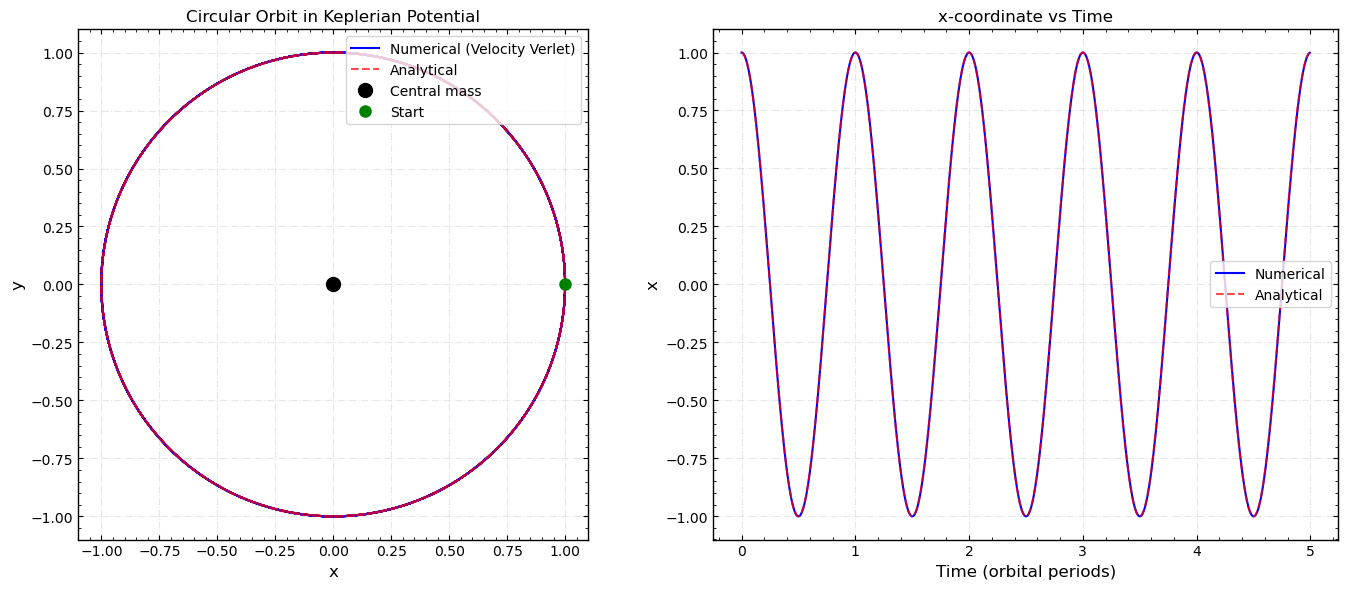

In [7]:
# Plot the orbit: numerical vs analytical
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Orbit in x-y plane
ax = axes[0]
ax.plot(pos_traj[:, 0], pos_traj[:, 1], 'b-', lw=1.5, label='Numerical (Velocity Verlet)')
ax.plot(x_analytical, y_analytical, 'r--', lw=1.5, label='Analytical', alpha=0.7)
ax.plot(0, 0, 'ko', ms=10, label='Central mass')
ax.plot(pos_init[0], pos_init[1], 'go', ms=8, label='Start')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Circular Orbit in Keplerian Potential', fontsize=12)
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Right: x(t) comparison
ax = axes[1]
ax.plot(t_array / T_orbit, pos_traj[:, 0], 'b-', lw=1.5, label='Numerical')
ax.plot(t_array / T_orbit, x_analytical, 'r--', lw=1.5, label='Analytical', alpha=0.7)
ax.set_xlabel('Time (orbital periods)', fontsize=12)
ax.set_ylabel('x', fontsize=12)
ax.set_title('x-coordinate vs Time', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('orbit_comparison.png', dpi=150)
plt.show()

In [8]:
# Compute position error over time
position_error = np.sqrt((pos_traj[:, 0] - x_analytical)**2 + 
                          (pos_traj[:, 1] - y_analytical)**2)

print(f"Position error after {n_orbits} orbits:")
print(f"  Maximum error: {np.max(position_error):.2e}")
print(f"  Final error: {position_error[-1]:.2e}")
print(f"  Error as fraction of orbit radius: {position_error[-1]/r0*100:.4f}%")

Position error after 5 orbits:
  Maximum error: 1.04e-02
  Final error: 1.03e-02
  Error as fraction of orbit radius: 1.0337%


---
## 6. Energy Conservation

One of the key advantages of symplectic integrators like Velocity Verlet is that they conserve energy very well over long integrations. The energy may oscillate slightly, but it doesn't systematically drift.

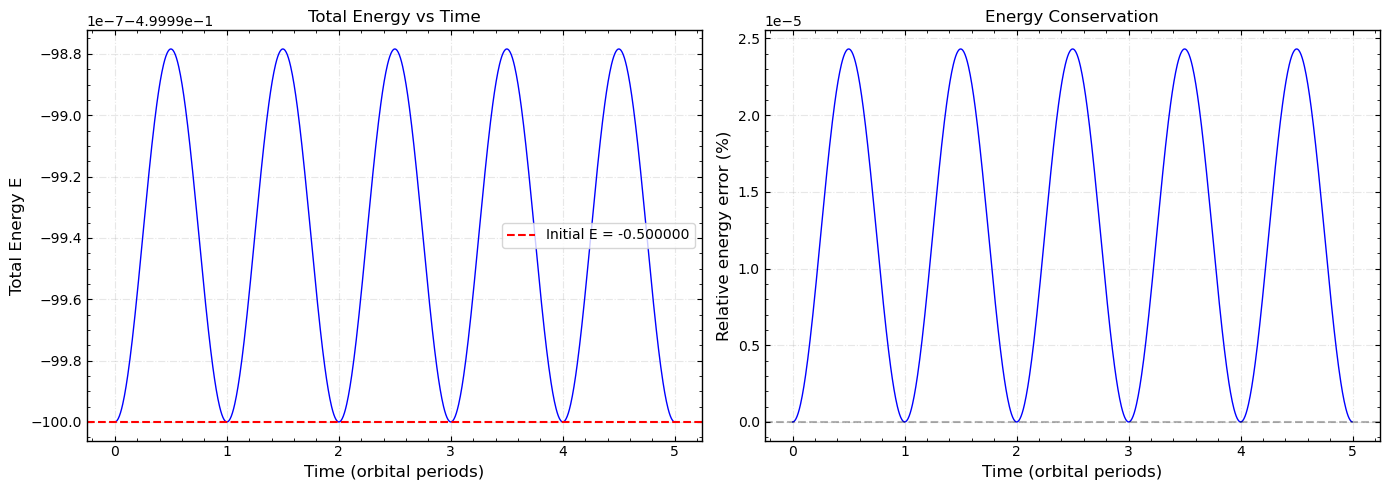

Energy conservation:
  Initial energy: E0 = -0.500000
  Final energy:   Ef = -0.500000
  Relative error: ΔE/E0 = 7.04e-11
  Max relative error: 2.43e-07


In [9]:
# Compute energy at each time step
energy = np.array([total_energy(pos_traj[i], vel_traj[i], GM) for i in range(n_steps)])
E0 = energy[0]
relative_energy_error = (energy - E0) / np.abs(E0)

# Plot energy conservation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute energy
ax = axes[0]
ax.plot(t_array / T_orbit, energy, 'b-', lw=1)
ax.axhline(E0, color='r', ls='--', label=f'Initial E = {E0:.6f}')
ax.set_xlabel('Time (orbital periods)', fontsize=12)
ax.set_ylabel('Total Energy E', fontsize=12)
ax.set_title('Total Energy vs Time', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Relative energy error
ax = axes[1]
ax.plot(t_array / T_orbit, relative_energy_error * 100, 'b-', lw=1)
ax.axhline(0, color='k', ls='--', alpha=0.3)
ax.set_xlabel('Time (orbital periods)', fontsize=12)
ax.set_ylabel('Relative energy error (%)', fontsize=12)
ax.set_title('Energy Conservation', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('energy_conservation.png', dpi=150)
plt.show()

print(f"Energy conservation:")
print(f"  Initial energy: E0 = {E0:.6f}")
print(f"  Final energy:   Ef = {energy[-1]:.6f}")
print(f"  Relative error: ΔE/E0 = {relative_energy_error[-1]:.2e}")
print(f"  Max relative error: {np.max(np.abs(relative_energy_error)):.2e}")

---
## 7. Comparison: Velocity Verlet vs Euler

To appreciate why Velocity Verlet is superior, let's compare it to the simple Euler method.

In [10]:
def integrate_euler(pos_init, vel_init, acc_func, dt, n_steps, **kwargs):
    """
    Integrate using the simple Euler method (for comparison).
    
    Euler method:
        x_{n+1} = x_n + v_n * dt
        v_{n+1} = v_n + a_n * dt
    """
    pos_traj = np.zeros((n_steps, 2))
    vel_traj = np.zeros((n_steps, 2))
    
    pos = np.array(pos_init, dtype=float)
    vel = np.array(vel_init, dtype=float)
    
    for i in range(n_steps):
        pos_traj[i] = pos
        vel_traj[i] = vel
        
        acc = acc_func(pos, **kwargs)
        
        # Simple Euler update (NOT recommended for orbits!)
        pos = pos + vel * dt
        vel = vel + acc * dt
    
    t_array = np.arange(n_steps) * dt
    return pos_traj, vel_traj, t_array


# Integrate with Euler
pos_euler, vel_euler, t_euler = integrate_euler(
    pos_init, vel_init, acceleration_kepler, dt, n_steps, GM=GM
)

# Compute energy for Euler
energy_euler = np.array([total_energy(pos_euler[i], vel_euler[i], GM) for i in range(n_steps)])
rel_error_euler = (energy_euler - E0) / np.abs(E0)

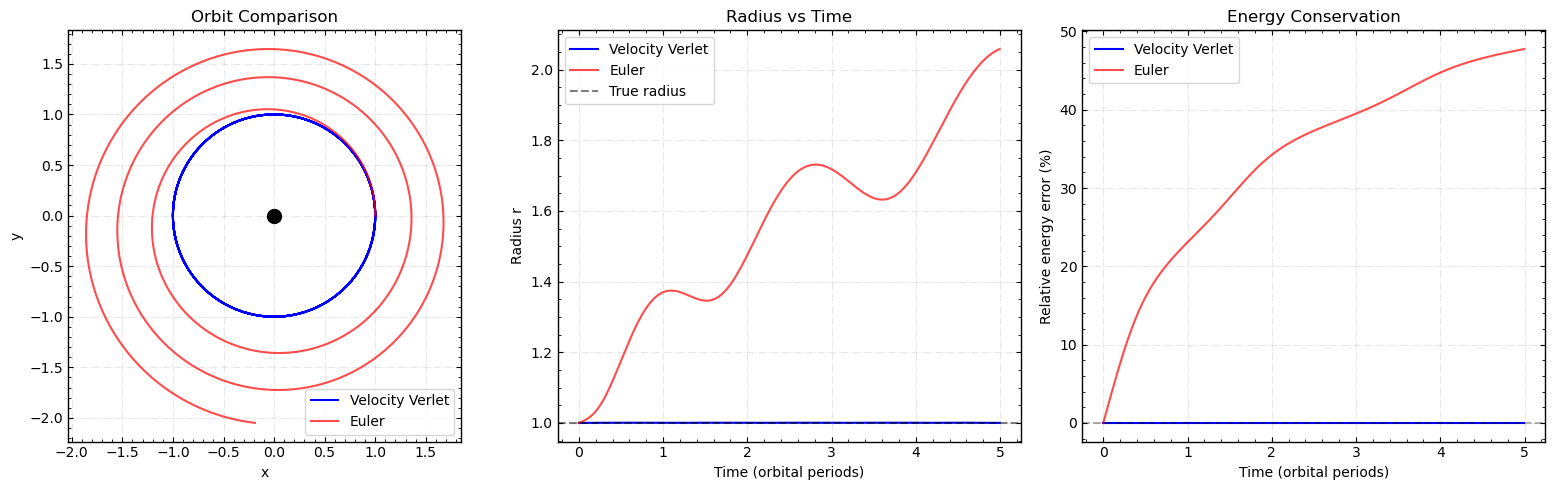


After 5 orbits:
  Velocity Verlet energy error: 0.0000%
  Euler energy error: 47.75%

Euler's energy error is 6778857171x larger!


In [11]:
# Compare orbits and energy
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Orbit comparison
ax = axes[0]
ax.plot(pos_traj[:, 0], pos_traj[:, 1], 'b-', lw=1.5, label='Velocity Verlet')
ax.plot(pos_euler[:, 0], pos_euler[:, 1], 'r-', lw=1.5, label='Euler', alpha=0.7)
ax.plot(0, 0, 'ko', ms=10)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Orbit Comparison')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)

# Radius vs time
ax = axes[1]
r_verlet = np.sqrt(pos_traj[:, 0]**2 + pos_traj[:, 1]**2)
r_euler = np.sqrt(pos_euler[:, 0]**2 + pos_euler[:, 1]**2)
ax.plot(t_array / T_orbit, r_verlet, 'b-', lw=1.5, label='Velocity Verlet')
ax.plot(t_euler / T_orbit, r_euler, 'r-', lw=1.5, label='Euler', alpha=0.7)
ax.axhline(r0, color='k', ls='--', alpha=0.5, label='True radius')
ax.set_xlabel('Time (orbital periods)')
ax.set_ylabel('Radius r')
ax.set_title('Radius vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Energy comparison
ax = axes[2]
ax.plot(t_array / T_orbit, relative_energy_error * 100, 'b-', lw=1.5, label='Velocity Verlet')
ax.plot(t_euler / T_orbit, rel_error_euler * 100, 'r-', lw=1.5, label='Euler', alpha=0.7)
ax.axhline(0, color='k', ls='--', alpha=0.3)
ax.set_xlabel('Time (orbital periods)')
ax.set_ylabel('Relative energy error (%)')
ax.set_title('Energy Conservation')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('verlet_vs_euler.png', dpi=150)
plt.show()

print(f"\nAfter {n_orbits} orbits:")
print(f"  Velocity Verlet energy error: {relative_energy_error[-1]*100:.4f}%")
print(f"  Euler energy error: {rel_error_euler[-1]*100:.2f}%")
print(f"\nEuler's energy error is {abs(rel_error_euler[-1]/relative_energy_error[-1]):.0f}x larger!")

---
## 8. Summary

### The Velocity Verlet Algorithm

```
Given: pos, vel, acc = acceleration(pos)

For each time step:
    1. pos_new = pos + vel * dt + 0.5 * acc * dt²
    2. acc_new = acceleration(pos_new)
    3. vel_new = vel + 0.5 * (acc + acc_new) * dt
    4. Update: pos = pos_new, vel = vel_new, acc = acc_new
```

### Key Properties

| Property | Euler | Velocity Verlet |
|----------|-------|----------------|
| Order of accuracy | 1st | 2nd |
| Symplectic | No | Yes |
| Energy conservation | Drifts | Bounded oscillations |
| Recommended for orbits | No | Yes |

### For Problem 3

You will use this same integrator to study orbits in the potential:
$$\Phi(r) = -\frac{b}{r} + (1-b)r^2$$

The only change needed is the acceleration function. The acceleration is:
$$\mathbf{a} = -\nabla\Phi = -\frac{d\Phi}{dr}\hat{r} = -\left(\frac{b}{r^2} + 2(1-b)r\right)\hat{r}$$

In Cartesian coordinates:
$$a_x = -\left(\frac{b}{r^3} + 2(1-b)\right)x, \quad a_y = -\left(\frac{b}{r^3} + 2(1-b)\right)y$$